In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

# For Sklearn warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn


In [2]:
cd ..

/Users/logang/Dropbox/GrosenickLab/Code/PCMF


In [3]:
def generate_PMD_data(m=100, n_X=10, sigma=1, density=0.5, mean=0, seed=1):
    "Generates data matrix for PCMF."
    np.random.seed(seed)
    u_star = np.random.randn(m) / 3.0
    v_star = np.random.randn(n_X) / 3.0
    X = np.random.normal(mean,sigma,size=((m,n_X))) / 3.0
    X_idxs = np.random.choice(range(n_X), int(density*n_X), replace=False)
    for idx in X_idxs:
        X[:,idx] += v_star[idx]*u_star

    return X, u_star, v_star

def generate_cluster_PMD_data(m=[50,50,20], n_X=20, sigma=0.075, density=1.0, n_clusters=3, 
                              means=[-0.35,0.2,0.35], gen_seeds=True, seeds=[], verbose=False):
    '''
    Generates multiple cluster data matrix for PCMF.
    '''
    X_out = []
    u_stars = []
    v_stars = []

    for nc in range(n_clusters):
        if gen_seeds is True:
            seed = np.random.randint(99999)
            seeds.append(seed)
            # print('generating seeds')                                                                                  
        # else:                                                                                                          
            # print(seeds)                                                                                               
            # print('NOT generating seeds')                                                                              

        if verbose == True:
            print(seeds)

        X, u_star, v_star = generate_PMD_data(m[nc], n_X, sigma, density, mean=means[nc], seed=seeds[nc])
        X_out.append(X)
        u_stars.append(u_star)
        v_stars.append(v_star)
    return X_out, u_stars, v_stars, seeds



Generate data

In [111]:
# Set data generation parameters
m = [100,20,20]
n_X = 20
sigma = 0.08
density = 1.0
n_clusters = 3
means = [-0.35, 0.0, 0.35]
true_clusters = np.repeat([0,1,2],m)

# Generate clusters
X_clusters, u_true, v_true, _ = generate_cluster_PMD_data(m, n_X, sigma, density, 
                                                          n_clusters=n_clusters, means=means, seeds=[1]) #8# row 1,3

# Add random intercept to one cluster and stack into data matrix
X_clusters[0] += 0.4
#X_clusters[0] += 0.3*np.random.randn(n_X)
X_c = np.vstack(X_clusters)


Set model parameters

In [112]:
num_clusters = 3
num_components = 4
colors = ['darkblue','darkorange','red','green','purple']
plot_idxs = [0,1]
scatter_cmap = 'tab20b'
scatter_alpha = 0.3

Plot generated data

(-0.5, 139.5, 139.5, -0.5)

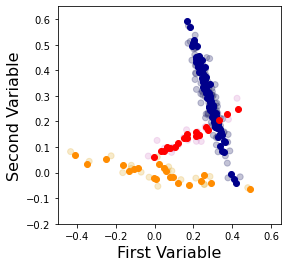

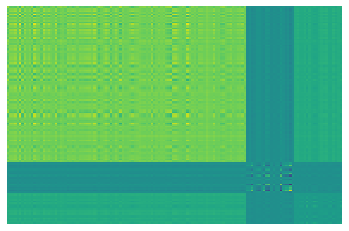

In [324]:
# Plot clusters
plt.figure(figsize=(4,4))
plt.scatter(X_c[:,plot_idxs[0]],X_c[:,plot_idxs[1]], c=true_clusters, cmap=scatter_cmap, alpha=scatter_alpha)
plt.xlim(-0.5, 0.65)
plt.ylim(-0.2, 0.65)
plt.xlabel('First Variable',fontsize=16)
plt.ylabel('Second Variable',fontsize=16)

# Plot PCA approximation with num_components components
X_pcas = list()
for ncl in range(num_clusters):
    idx = np.where(true_clusters==ncl)[0]
    u,d,vh = np.linalg.svd(X_c[idx,:], full_matrices=False)
    X_pca = np.dot(np.dot(u[:,0:num_components],np.diag(d[0:num_components])),vh[0:num_components,:])
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors[ncl])

# Plot Covariance
plt.figure()
C = np.dot(X_c,X_c.T)
maxval = np.max(np.abs(C))
plt.imshow(C,aspect='auto',interpolation='nearest',cmap='viridis',vmin=-1*maxval, vmax=maxval)  
plt.axis('off')



Clustering then PCA

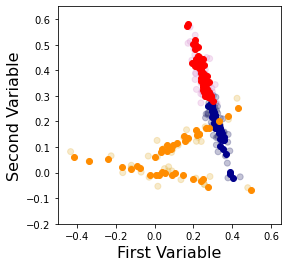

In [325]:
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans

# Cluster
spectral_clustering = SpectralClustering(n_clusters=num_clusters, random_state=20, affinity="nearest_neighbors").fit(X_c)
spectral_labels = spectral_clustering.labels_
#kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(X_c)
#kmeans_labels = kmeans.labels_

# Plot PCA
plt.figure(figsize=(4,4))
plt.scatter(X_c[:, plot_idxs[0]], X_c[:, plot_idxs[1]], c=spectral_labels, cmap=scatter_cmap, alpha=scatter_alpha)
plt.xlim(-0.5, 0.65)
plt.ylim(-0.2, 0.65)
plt.xlabel('First Variable',fontsize=16)
plt.ylabel('Second Variable',fontsize=16)

X_pcas = list()
for ncl in range(num_clusters):
    idx = np.where(spectral_labels==ncl)[0]
    u,d,vh = np.linalg.svd(X_c[idx,:], full_matrices=False)
    X_pca = np.dot(np.dot(u[:,0:num_components],np.diag(d[0:num_components])),vh[0:num_components,:])
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors[ncl])

plt.show()


PCA then Clustering

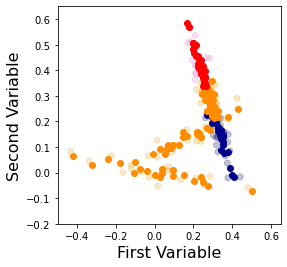

In [326]:
# Fit PCA + spectral clustering
u,d,vh = np.linalg.svd(X_c, full_matrices=False)
pca_spectral_clustering = SpectralClustering(n_clusters=num_clusters, random_state=20, affinity="nearest_neighbors").fit(u[:,0:num_components])
pca_labels = pca_spectral_clustering.labels_

# Plot results
plt.figure(figsize=(4,4))
plt.scatter(X_c[:,0], X_c[:,1], c=pca_labels, cmap=scatter_cmap, alpha=scatter_alpha)
plt.xlim(-0.5, 0.65)
plt.ylim(-0.2, 0.65)
plt.xlabel('First Variable',fontsize=16)
plt.ylabel('Second Variable',fontsize=16)

X_pcas = list()
for ncl in range(num_clusters):
    idx = np.where(pca_labels==ncl)[0]
    u,d,vh = np.linalg.svd(X_c[idx,:], full_matrices=False)
    X_pca = np.dot(np.dot(u[:,0:num_components],np.diag(d[0:num_components])),vh[0:num_components,:])
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors[ncl])

#plt.axis('off')


Set the penalty list for experiments

In [116]:
penalty_list = np.concatenate((np.repeat(np.inf,10),np.exp(np.linspace(-20,5,250))[::-1]),axis=0)


### Run PCMF on synthetic data

In [322]:
from matplotlib import cm

def path_plot(coefficient_arr, penalty_list, plot_range=[0,-1], cut_vars=False, 
              first_vars_only=False, var_sel=1, true_clusters=None,figsize=(20,10)):
    # Crop x axis (e.g, to remove 'burn-in' period at beginning)                                                         
    coefficient_arr = coefficient_arr[plot_range[0]:plot_range[1],:,:]
    penalty_list = penalty_list[plot_range[0]:plot_range[1]]
    if cut_vars is True:
        coefficient_arr = coefficient_arr[:,:,[1,2,coefficient_arr.shape[2]-1]]

    if first_vars_only is True:
        coefficient_arr = coefficient_arr[:,:,[var_sel]]

    # Colormap                                                                                                           
    cmap = matplotlib.cm.get_cmap('tab20b')

    #cm.get_cmap('viridis', coefficient_arr.shape[2])
    colors = cmap(np.linspace(0.0,1.0,3))
    
    # Define x-axis range                                                                                                
    penalty_range = range(len(penalty_list))

    # Make figure
    fig, ax = plt.subplots(1,1, figsize=figsize)

    for i in range(coefficient_arr.shape[2]):
        x = np.round(np.array(penalty_list),8)[penalty_range]
        y = coefficient_arr[penalty_range,:,i]
        if true_clusters is not None:
            # Make different line types for different clusters
            linetypes = ['dotted']*len(true_clusters)
            color_list = [colors[i]]*len(true_clusters)
            for j, tc in enumerate(true_clusters):
                if tc == 1:
                    linetypes[j] = 'solid'
                    color_list[j] = colors[tc]
                elif tc == 2:
                    linetypes[j] = 'dashed'
                    color_list[j] = colors[tc]
                elif tc == 3:
                    linetypes[j] = 'dashdot'
                    color_list[j] = colors[tc]
                else:
                    linetypes[j] = 'dotted'
                    color_list[j] = colors[tc]

            # Plot the lines and set linestyle
            ax.plot(np.arange(x.shape[0]), y, color=colors[i], alpha=0.5)
            for l, line in enumerate(ax.get_lines()):
                line.set_linestyle(linetypes[l])
                line.set_color(color_list[l])
        else:
            ax.plot(np.arange(x.shape[0]), y, color=colors[i], alpha=0.5)
        # Set plot ticks and labels
        ax.set_xticks(range(x.shape[0]), minor=False);
        plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
        ax.set_xticklabels(x) #,fontsize=24)
        evens = np.arange(0,len(ax.xaxis.get_ticklabels())+1,2)
    for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)
    ax.tick_params(axis='y') #, labelsize=24)
    plt.xlabel(r'$\lambda$',fontsize=16)
    plt.ylabel('Coefficients',fontsize=16)
    sns.despine()
    

Divisive pathwise clustering

In [118]:
from pcmf import pcmf_full, pcmf_approx_uV, plot_ordercolor, plot_cluster_assignments

gc = 2.0 

# Fit full model
A_list, U_list, s_list, V_list = pcmf_full(X_c, penalty_list, problem_rank=num_components, rho=1.0, gauss_coef=gc, weights='Gaussian', admm_iters = 10, neighbors=25)

# Fit partial u,V model
#V_list_approx_uV, u_list_approx_uV, s_list_approx_uV =  pcmf_approx_uV(X_c, penalty_list, rho=1.5, gauss_coef=gc, weights='Gaussian', admm_iters = 5, neighbors=15)


weights: Gaussian neighbors: 25 gauss_coef: 2.0 rho: 1.0
[ 1 ] inf...

/Users/logang/Dropbox/GrosenickLab/Code/PCMF/pcmf.py:555: RuntimeWarning: invalid value encountered in double_scalars
  G = cprox(D*A+Z1, penalty, rho, weights)


[ 2 ] inf...[ 3 ] inf...[ 4 ] inf...[ 5 ] inf...[ 6 ] inf...[ 7 ] inf...[ 8 ] inf...[ 9 ] inf...[ 10 ] inf...[ 11 ] 1.48413e+02...[ 12 ] 1.34236e+02...[ 13 ] 1.21413e+02...[ 14 ] 1.09815e+02...[ 15 ] 9.93246e+01...[ 16 ] 8.98366e+01...[ 17 ] 8.12548e+01...[ 18 ] 7.34929e+01...[ 19 ] 6.64724e+01...[ 20 ] 6.01226e+01...[ 21 ] 5.43793e+01...[ 22 ] 4.91847e+01...[ 23 ] 4.44863e+01...[ 24 ] 4.02367e+01...[ 25 ] 3.63930e+01...[ 26 ] 3.29166e+01...[ 27 ] 2.97722e+01...[ 28 ] 2.69282e+01...[ 29 ] 2.43558e+01...[ 30 ] 2.20292e+01...[ 31 ] 1.99249e+01...[ 32 ] 1.80215e+01...[ 33 ] 1.63000e+01...[ 34 ] 1.47429e+01...[ 35 ] 1.33346e+01...[ 36 ] 1.20608e+01...[ 37 ] 1.09087e+01...[ 38 ] 9.86661e+00...[ 39 ] 8.92410e+00...[ 40 ] 8.07161e+00...[ 41 ] 7.30057e+00...[ 42 ] 6.60317e+00...[ 43 ] 5.97240e+00...[ 44 ] 5.40188e+00...[ 45 ] 4.88586e+00...[ 46 ] 4.41913e+00...[ 47 ] 3.99699e+00...[ 48 ] 3.61518e+00...[ 49 ] 3.26983e+00...[ 50 ] 2.95748e+00...[ 51 ] 2.67496e+00...[ 52 ] 2.41944e+00...[ 53 ] 2.

In [119]:
from scipy.sparse import csr_matrix
from itertools import combinations
import networkx as nx
from scipy.stats import norm
from sklearn.mixture import GaussianMixture

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

def sparse_D(n,p):
    '''                                                                                                                  
    Construct a sparse matrix, that when applied to a vector containing concatenated vectors                             
    of coefficients b = [b_1 b_2 ... b_n] where each b_i is p=num_var long and there are                                 
    n = num_vec of them. Differences are taken between conformal elements (e.g. b_11 and b_21)                           
    across all unique pairwise combinations of vectors.                                                                  
    '''
    comb_list = list(combinations(range(n),2))
    combs_arr = np.array(comb_list)
    num_combs = combs_arr.shape[0]
    data = np.ones_like(combs_arr)
    data[:,1] *= -1
    row = np.repeat(range(num_combs),2)
    col = combs_arr.flatten()
    return csr_matrix((data.flatten(), (row, col)), shape=(num_combs, n)), comb_list

def diff_graph_cluster(Xhat, D, comb_list, num_clusters, thresh_sd=6, pca_clean=True, num_fits=1, verbose=False):
    '''
    Given a PCMF data approximation 'Xhat' for a fixed lambda and a differencing matrix 'D', calculate the 
    difference variable graph as suggested in Chi and Lange JCGC (2015), clustering on the graph adjacency 
    matrix (or a PCA embedding of it if pca_clean=True).
    
    Args:
        Xhat - PCMF data approximation at a fixed penalty parameter.
        D - a sparse differencing matrix given by 'sparse_D'.
        comb_list - the combination indices returned by 'sparse_D'.
        num_clusters - the number of clusters.
        thresh_sd - a threshold standard deviation cuttoff for thresholding the difference graph.
        pca_clean - boolean; should the PCA of the adjacency matrix be used for clustering. 
        num_fits - number of spectral clusterings to take the median of for output. 
        verbose - Print threshold adjustment; plot histogram graph edges and show GMM fit used to choose threshold.

    '''
    # Get graph edges from distances, and estimate graph threshold from edge mode centered around zero
    edges = np.sum(D*Xhat,axis=1)
    #edges = np.median(D*Xhat,axis=1)

    gmm = GaussianMixture(n_components = 6, max_iter=200, n_init=10).fit(edges.reshape(-1, 1))
    zero_mode_idx = np.where(np.abs(gmm.means_)==np.min(np.abs(gmm.means_)))[0]
    thresh = thresh_sd*np.sqrt(gmm.covariances_[zero_mode_idx])
    
    # Make adjacency from sum of differences (and adjust threshold if necessary) 
    flag = True
    while flag==True:
        # Generate graph
        G = nx.Graph()
        for i,e in enumerate(edges):
            if np.abs(e) < thresh:
                G.add_edge(comb_list[i][0], comb_list[i][1])
        A = nx.adjacency_matrix(G).toarray()
        if verbose:
            print('threshold:',thresh)
        if A.shape[0] < Xhat.shape[0]:
            thresh *= 1.1
        else:
            flag = False
            
    # Apply spectral clustering, taking median of 'num_fits' tryes to get output labels
    out_labels = []
    for f in range(num_fits):
        # Use PCA of A if 'pca_clean' flag set
        if pca_clean:
            uA, sA, vhA = np.linalg.svd(A)
            spectral_clustering = SpectralClustering(n_clusters=num_clusters, random_state=20, affinity="nearest_neighbors").fit(uA[:,0:num_clusters])
            out_labels.append(spectral_clustering.labels_)
        else:
            spectral_clustering = SpectralClustering(n_clusters=num_clusters, random_state=20, affinity="nearest_neighbors").fit(A)
            out_labels.append(spectral_clustering.labels_)
            
    # Plot thresholding histogram if 'plot_thresh_hist' is true
    if verbose:
        plt.figure(figsize=(10,5))
        _ = plt.hist(edges,bins=100,density=True)

        f_axis = edges.copy().ravel()
        f_axis.sort()
        a = []
        for weight, mean, covar in zip(gmm.weights_, gmm.means_, gmm.covariances_):
            a.append(weight*norm.pdf(f_axis, mean, np.sqrt(covar)).ravel())
            plt.plot(f_axis, a[-1])
        plt.plot(f_axis, np.array(a).sum(axis=0), 'k-')
        plt.xlabel('Variable')
        plt.ylabel('PDF')
        plt.tight_layout()
        plt.show()
        
    return np.median(np.array(out_labels),axis=0)

D, comb_list = sparse_D(X_c.shape[0],X_c.shape[1])



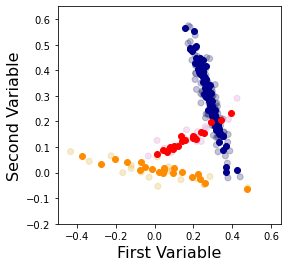

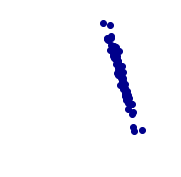

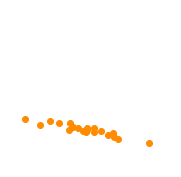

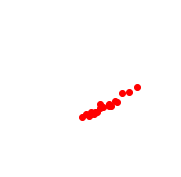

In [327]:
# Plot results for one value of lambda with data and PCMF estimate overlay
plt.figure(figsize=(4,4))
plt.scatter(X_c[:,0], X_c[:,1], c=true_clusters, cmap=scatter_cmap, alpha=scatter_alpha) 
plt.xlabel('First Variable',fontsize=16)
plt.ylabel('Second Variable',fontsize=16)

lambda_idx = 135
U = U_list[lambda_idx]
s = s_list[lambda_idx]
V = V_list[lambda_idx]

cluster_pcmf = diff_graph_cluster(np.array(A_list[lambda_idx]), D, comb_list, num_clusters).astype(int)

#X_pcmf = np.dot(np.dot(U[:,0:num_components],np.diag(s[0:num_components])),V[0:num_components,:])
#pcmf_spectral_clustering = SpectralClustering(n_clusters=num_clusters, random_state=20, affinity="nearest_neighbors").fit()
#pcmf_labels = pcmf_spectral_clustering.labels_

#plt.figure(figsize=(6,6))
X_pcas = list()
for ncl in range(num_clusters):
    idx = np.where(cluster_pcmf==ncl)[0]
    X_pcmf = np.dot(np.dot(U[:,0:num_components],np.diag(s[0:num_components])),V[0:num_components,:])
    plt.scatter(X_pcmf[idx, 0], X_pcmf[idx, 1], c=colors[ncl])
    plt.xlim(-0.5, 0.65)
    plt.ylim(-0.2, 0.65)
    
X_pcas = list()
for ncl in range(num_clusters):
    plt.figure(figsize=(3,3))
    idx = np.where(cluster_pcmf==ncl)[0]
    X_pcmf = np.dot(np.dot(U[:,0:num_components],np.diag(s[0:num_components])),V[0:num_components,:])
    plt.scatter(X_pcmf[idx, 0], X_pcmf[idx, 1], c=colors[ncl])
    plt.xlim(-0.5, 0.65)
    plt.ylim(-0.2, 0.65)
    plt.axis("off")

    

[Text(0, 0.5, 'Second Variable')]

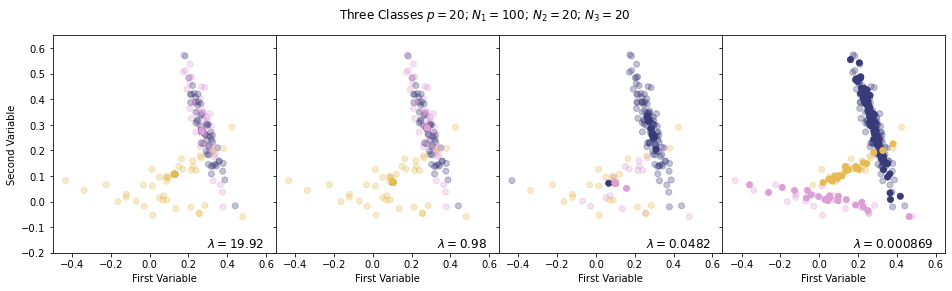

In [136]:
# Plot four clusterings with data and PCMF overlay
idxs = [30,60,90,130]
rounds = [2,3,4,7]
fig = plt.figure(figsize=(16,4))
gs = fig.add_gridspec(1, 4, hspace=0, wspace=0)
axs = gs.subplots(sharex=True, sharey=True)
fig.suptitle(r'Three Classes $p=%i$;'%n_X + ' $N_1=%i$;'%m[0]+' $N_2=%i$;'%m[1]+' $N_3=%i$'%m[2])

for a,ax in enumerate(axs):
    idx = idxs[a]
    cluster_pcmf = diff_graph_cluster(np.array(A_list[idx]), D, comb_list, num_clusters).astype(int)
    ax.scatter(X_c[:,0], X_c[:,1], c=cluster_pcmf, alpha=scatter_alpha, cmap=scatter_cmap)
    plt.xlim(-0.5, 0.65)
    plt.ylim(-0.2, 0.65)
    #plt.axis("off")
    
    #plt.figure(figsize=(6,6))
    #Xhat_approxUV_list = []
    #for i in range(len(penalty_list)):
    #    Xhat_approxUV_list.append(u_list_approx_uV[i] * V_list_approx_uV[i]*s_list[i][0])  
    #ax.scatter(np.asarray(Xhat_approxUV_list)[idx,:,0],np.asarray(Xhat_approxUV_list)[idx,:,1], c=true_clusters, cmap='bwr')
    #plt.axis("off")

    ax.scatter(np.asarray(A_list)[idx,:,0],np.asarray(A_list)[idx,:,1], c=cluster_pcmf, cmap=scatter_cmap)
    ax.set(xlabel="First Variable")
    ax.text(0.95, 0.01, r"$\lambda =$"+str(np.round(penalty_list[idx],rounds[a])),
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        color='black', fontsize=12)
    
    #plt.axis("off")
axs[0].set(ylabel="Second Variable")




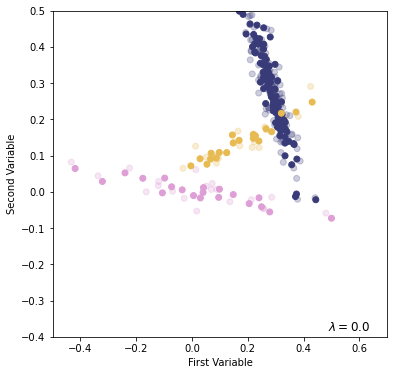

In [135]:
# Generate video of solutions along path
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.animation as manimation

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib', comment='Movie support!')
writer = FFMpegWriter(fps=15, metadata=metadata)

#Xhat_approxUV_list = []
#for i in range(len(penalty_list)):
#    Xhat_approxUV_list.append(u_list_approx_uV[i] * V_list_approx_uV[i]*s_list[i][0])  
#plt.axis("off")

Xhat_list = []
for i in range(len(penalty_list)):
    Xhat_list.append(np.dot(np.dot(U_list[i],np.diag(s_list[i])),V_list[i])) 

fig = plt.figure(figsize=(6,6))
l = plt.scatter([], [])

plt.xlim(-0.5, 0.65)
plt.ylim(-0.2, 0.65)

#x0 = Xu_preds[0] 
#y0 = Yv_preds[0]

ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

with writer.saving(fig, "writer_test.mp4", 300):
    for i in range(len(penalty_list)):
        fig.clear()
        ax = fig.add_subplot(111, autoscale_on=False, xlim=(-0.6, 0.6), ylim=(-0.6, 0.6))
        cluster_pcmf = diff_graph_cluster(np.array(A_list[i]), D, comb_list, num_clusters).astype(int)

        ax.scatter(X_c[:,0],X_c[:,1],c=cluster_pcmf, alpha=0.25, cmap=scatter_cmap)

        #ax.scatter(np.asarray(Xhat_approxUV_list)[i,:,0],np.asarray(Xhat_approxUV_list)[i,:,1], c=true_clusters, cmap='bwr')
        #ax.scatter(np.asarray(Xhat_list)[i,:,0],np.asarray(Xhat_list)[i,:,1], c=true_clusters, cmap='PiYG')
        ax.scatter(np.asarray(A_list)[i,:,0],np.asarray(A_list)[i,:,1], c=cluster_pcmf, cmap=scatter_cmap)
        ax.set(xlabel="First Variable")
        ax.set(ylabel="Second Variable")
        ax.text(0.95, 0.01, r"$\lambda =$"+str(np.round(penalty_list[i],5)),
            verticalalignment='bottom', horizontalalignment='right',
            transform=ax.transAxes,
            color='black', fontsize=12)
        
        ax.set_xlim(-0.5, 0.7)
        ax.set_ylim(-0.4, 0.5)
        
        #ax.set_xlabel("Brain Connectivity Canonical Variate")
        #ax.set_ylabel("Clinical Scale Canonical Variate")
        #ax.axes.xaxis.set_visible(False)
        #ax.axes.yaxis.set_visible(False)
        #pcmf_cca_labels_old = pcmf_cca_labels.copy()
        #pcmf_cca_labels = v_metrics.cluster_along_path(i,c_type='kmeans')
        #if np.sum(pcmf_cca_labels != pcmf_cca_labels_old) > np.sum(pcmf_cca_labels == pcmf_cca_labels_old):
        #    pcmf_cca_labels = 1-pcmf_cca_labels
        
        #c0 = np.where(pcmf_cca_labels == 0)[0]
        #c1 = np.where(pcmf_cca_labels == 1)[0]
        #ax.scatter(Xu_preds[i][c0],Yv_preds[i][c0], c='green');
        #ax.scatter(Xu_preds[i][c1],Yv_preds[i][c1], c='black');
        #ax.text(0.95, 0.01, r"$log(\lambda) =$"+str(np.round(np.log(penalty_list[i]),3)),
        #    verticalalignment='bottom', horizontalalignment='right',
        #    transform=ax.transAxes,
        #    color='black', fontsize=12)
        
        #s = ax.scatter(Xu_preds[i], Yv_preds[i], c=pcmf_cca_labels, cmap="RdBu_r", marker="o", edgecolor='black')

        #x0 = Xu_preds[i] 
        #y0 = Yv_preds[i]
        #pcmf_cca_labels = v_metrics.cluster_along_path(i)        
        #l.set_offsets(np.vstack((x0,y0)).T)
        #l.set_array(pcmf_cca_labels)
        #l.set_color(cols)
        writer.grab_frame()
        

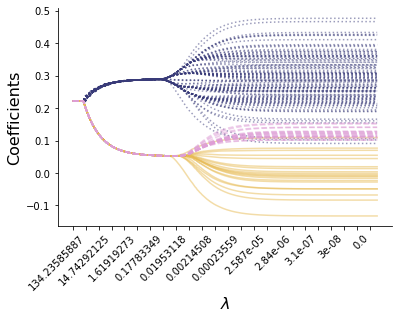

In [323]:
path_plot(np.asarray(A_list)[:,:,6:7], penalty_list, plot_range=[0,len(penalty_list)],cut_vars=False, true_clusters=true_clusters,figsize=(6,4))
plt.locator_params(axis='x',nbins=25)



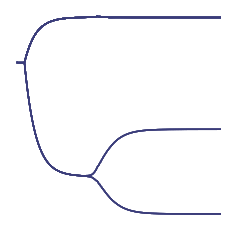

In [171]:
import seaborn as sns

def plot_dendrogram(Xhat,problem_rank,true_clusters_all,n_infinities,penalty_list):
    from pcmf import centroid_matrix
    Xhat_centroids = []
    for p in range(len(penalty_list)):
        Xhat_centroids.append(centroid_matrix(np.array(Xhat[p]),true_clusters_all))
    path_plot(np.asarray(Xhat_centroids)[:,:,6:7], penalty_list, plot_range=[n_infinities,-1],figsize=(4,4))
    plt.ylabel("$\hat{X}$ Rank "+str(problem_rank+1))
    plt.locator_params(axis='x',nbins=25)
    ax = plt.gca()
    ax.patch.set_facecolor('white')
    #plt.grid(b=None)
    #fig = plt.gcf()
    #fig.set_figheight(3)
    plt.axis('off')
    #ax.axes.get_yaxis().set_visible(False)
    #sns.despine()

cluster_pcmf = diff_graph_cluster(np.array(A_list[130]), D, comb_list, num_clusters).astype(int)
plot_dendrogram(np.asarray(A_list),num_components,cluster_pcmf,0,penalty_list)
    

array([12.90559413,  4.53270277,  2.75696725,  2.01980684])

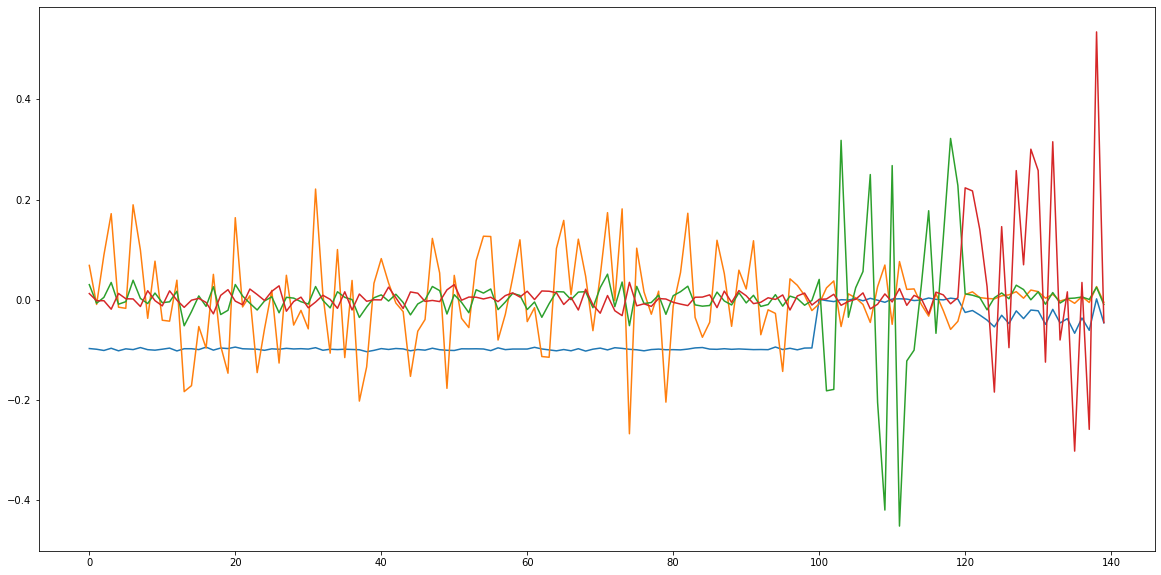

In [18]:
plt.figure(figsize=(20,10))
plt.plot(np.array(U_list[130]))
np.array(s_list[130])



In [293]:
import time 
from pcmf import pcmf_full_consensus

def pcmf_full_consensus_byrank(X_all, penalty_list, split_size=0, fontsize=16, max_problem_rank=5, rho=1.0, admm_iters=10, weights='Gaussian', gauss_coef=2.0, neighbors=10, print_progress=True, parallel=False, output_file='nan'):
    As = []
    Us = []
    Ss = []
    Vs = []
    As_its = []
    if split_size==0:
        split_size =X_all.shape[0]
    #
    for problem_rank in range(0,max_problem_rank):
        tic=time.time()
        print('Problem rank '+str(problem_rank))
        A, U, S, V = pcmf_full_consensus(X_all, penalty_list, split_size=split_size, rho=rho, admm_iters=admm_iters, weights=weights, gauss_coef=gauss_coef, problem_rank=problem_rank+1, neighbors=neighbors, print_progress=True, parallel=parallel, output_file=output_file)
        As.append(A)
        Us.append(U)
        Ss.append(S)
        Vs.append(V)
        toc=time.time() - tic
    return As, Us, Ss, Vs
    #
def plot_variance_byrank(Ss,As,true_clusters_all,n_infinities,penalty_list, max_rank=10, fontsize=16):

    fig = plt.figure(figsize=(8,4))
    ax = fig.add_subplot(111)
    ax.patch.set_facecolor('white')
    plt.xlabel('Problem Rank (r)',fontsize=fontsize)
    plt.ylabel('Norm. Variance Explained',fontsize=fontsize)
    plt.grid(b=None)
    colors = cm.rainbow(np.linspace(1, 0, len(penalty_list)-n_infinities))
    c = 0
    for k in np.arange(n_infinities,len(penalty_list),1):
        P = []
        for i,S in enumerate(Ss):
            P.append( np.sum(S[k][1:len(S[k])]**2)/np.sum(Ss[-1][-1][1:len(Ss[-1][-1])]**2) )
        #
        plt.plot(np.arange(1,len(Ss)+1),P,'o-',color=colors[c,:],alpha=0.5)
        if c==95:
            plt.plot(np.arange(1,len(Ss)+1),P,'*-',color='black',linewidth=5)
        c = c + 1
    plt.xticks(fontsize=fontsize,rotation=0)
    plt.yticks(fontsize=fontsize,rotation=0)
    plt.xticks(range(1,max_rank,4), range(2,max_rank,4), rotation=0)
    
    mymap = matplotlib.colors.LinearSegmentedColormap.from_list('colors',colors)
    sm = plt.cm.ScalarMappable(cmap=mymap, norm=plt.Normalize(vmin=n_infinities, vmax=len(penalty_list)-n_infinities ))
    cbar = plt.colorbar(sm,)
    cbar.ax.set_title('$\lambda$', rotation=0, fontsize=fontsize)
    cbar.ax.tick_params(labelsize=fontsize)
    cbar.ax.set_yticklabels(['134', '1.6','0.02','0.0002','2.5e-6','0'])  # vertically oriented colorbar

    
    for problem_rank in range(0,len(Ss)):
        plot_dendrogram(As[problem_rank],problem_rank,true_clusters_all,n_infinities,penalty_list)



In [190]:
# Calculate PCMF ADMM model for each problem rank
As, Us, Ss, Vs = pcmf_full_consensus_byrank(X_c, penalty_list, split_size=0, fontsize=16, max_problem_rank=X_c.shape[1], rho=1.0, admm_iters=10, weights='Gaussian', gauss_coef=gc, neighbors=25) #, print_progress=print_progress, parallel=parallel, output_file=output_file)


Problem rank 0
weights: Gaussian neighbors: 25 gauss_coef: 2.0 rho: 1.0
rho1: 1.0 rho2 1.0
Number of batches: 1
Initialize IDX: 0
Means matrix has shape: (140, 20)
[ 1 ] inf...[ 2 ] inf...[ 3 ] inf...[ 4 ] inf...[ 5 ] inf...[ 6 ] inf...[ 7 ] inf...[ 8 ] inf...[ 9 ] inf...[ 10 ] inf...[ 11 ] 1.48413e+02...[ 12 ] 1.34236e+02...[ 13 ] 1.21413e+02...[ 14 ] 1.09815e+02...[ 15 ] 9.93246e+01...[ 16 ] 8.98366e+01...[ 17 ] 8.12548e+01...[ 18 ] 7.34929e+01...[ 19 ] 6.64724e+01...[ 20 ] 6.01226e+01...[ 21 ] 5.43793e+01...[ 22 ] 4.91847e+01...[ 23 ] 4.44863e+01...[ 24 ] 4.02367e+01...[ 25 ] 3.63930e+01...[ 26 ] 3.29166e+01...[ 27 ] 2.97722e+01...[ 28 ] 2.69282e+01...[ 29 ] 2.43558e+01...[ 30 ] 2.20292e+01...[ 31 ] 1.99249e+01...[ 32 ] 1.80215e+01...[ 33 ] 1.63000e+01...[ 34 ] 1.47429e+01...[ 35 ] 1.33346e+01...[ 36 ] 1.20608e+01...[ 37 ] 1.09087e+01...[ 38 ] 9.86661e+00...[ 39 ] 8.92410e+00...[ 40 ] 8.07161e+00...[ 41 ] 7.30057e+00...[ 42 ] 6.60317e+00...[ 43 ] 5.97240e+00...[ 44 ] 5.40188e+00...[

[ 1 ] inf...[ 2 ] inf...[ 3 ] inf...[ 4 ] inf...[ 5 ] inf...[ 6 ] inf...[ 7 ] inf...[ 8 ] inf...[ 9 ] inf...[ 10 ] inf...[ 11 ] 1.48413e+02...[ 12 ] 1.34236e+02...[ 13 ] 1.21413e+02...[ 14 ] 1.09815e+02...[ 15 ] 9.93246e+01...[ 16 ] 8.98366e+01...[ 17 ] 8.12548e+01...[ 18 ] 7.34929e+01...[ 19 ] 6.64724e+01...[ 20 ] 6.01226e+01...[ 21 ] 5.43793e+01...[ 22 ] 4.91847e+01...[ 23 ] 4.44863e+01...[ 24 ] 4.02367e+01...[ 25 ] 3.63930e+01...[ 26 ] 3.29166e+01...[ 27 ] 2.97722e+01...[ 28 ] 2.69282e+01...[ 29 ] 2.43558e+01...[ 30 ] 2.20292e+01...[ 31 ] 1.99249e+01...[ 32 ] 1.80215e+01...[ 33 ] 1.63000e+01...[ 34 ] 1.47429e+01...[ 35 ] 1.33346e+01...[ 36 ] 1.20608e+01...[ 37 ] 1.09087e+01...[ 38 ] 9.86661e+00...[ 39 ] 8.92410e+00...[ 40 ] 8.07161e+00...[ 41 ] 7.30057e+00...[ 42 ] 6.60317e+00...[ 43 ] 5.97240e+00...[ 44 ] 5.40188e+00...[ 45 ] 4.88586e+00...[ 46 ] 4.41913e+00...[ 47 ] 3.99699e+00...[ 48 ] 3.61518e+00...[ 49 ] 3.26983e+00...[ 50 ] 2.95748e+00...[ 51 ] 2.67496e+00...[ 52 ] 2.41944e+00

[ 1 ] inf...[ 2 ] inf...[ 3 ] inf...[ 4 ] inf...[ 5 ] inf...[ 6 ] inf...[ 7 ] inf...[ 8 ] inf...[ 9 ] inf...[ 10 ] inf...[ 11 ] 1.48413e+02...[ 12 ] 1.34236e+02...[ 13 ] 1.21413e+02...[ 14 ] 1.09815e+02...[ 15 ] 9.93246e+01...[ 16 ] 8.98366e+01...[ 17 ] 8.12548e+01...[ 18 ] 7.34929e+01...[ 19 ] 6.64724e+01...[ 20 ] 6.01226e+01...[ 21 ] 5.43793e+01...[ 22 ] 4.91847e+01...[ 23 ] 4.44863e+01...[ 24 ] 4.02367e+01...[ 25 ] 3.63930e+01...[ 26 ] 3.29166e+01...[ 27 ] 2.97722e+01...[ 28 ] 2.69282e+01...[ 29 ] 2.43558e+01...[ 30 ] 2.20292e+01...[ 31 ] 1.99249e+01...[ 32 ] 1.80215e+01...[ 33 ] 1.63000e+01...[ 34 ] 1.47429e+01...[ 35 ] 1.33346e+01...[ 36 ] 1.20608e+01...[ 37 ] 1.09087e+01...[ 38 ] 9.86661e+00...[ 39 ] 8.92410e+00...[ 40 ] 8.07161e+00...[ 41 ] 7.30057e+00...[ 42 ] 6.60317e+00...[ 43 ] 5.97240e+00...[ 44 ] 5.40188e+00...[ 45 ] 4.88586e+00...[ 46 ] 4.41913e+00...[ 47 ] 3.99699e+00...[ 48 ] 3.61518e+00...[ 49 ] 3.26983e+00...[ 50 ] 2.95748e+00...[ 51 ] 2.67496e+00...[ 52 ] 2.41944e+00

[ 1 ] inf...[ 2 ] inf...[ 3 ] inf...[ 4 ] inf...[ 5 ] inf...[ 6 ] inf...[ 7 ] inf...[ 8 ] inf...[ 9 ] inf...[ 10 ] inf...[ 11 ] 1.48413e+02...[ 12 ] 1.34236e+02...[ 13 ] 1.21413e+02...[ 14 ] 1.09815e+02...[ 15 ] 9.93246e+01...[ 16 ] 8.98366e+01...[ 17 ] 8.12548e+01...[ 18 ] 7.34929e+01...[ 19 ] 6.64724e+01...[ 20 ] 6.01226e+01...[ 21 ] 5.43793e+01...[ 22 ] 4.91847e+01...[ 23 ] 4.44863e+01...[ 24 ] 4.02367e+01...[ 25 ] 3.63930e+01...[ 26 ] 3.29166e+01...[ 27 ] 2.97722e+01...[ 28 ] 2.69282e+01...[ 29 ] 2.43558e+01...[ 30 ] 2.20292e+01...[ 31 ] 1.99249e+01...[ 32 ] 1.80215e+01...[ 33 ] 1.63000e+01...[ 34 ] 1.47429e+01...[ 35 ] 1.33346e+01...[ 36 ] 1.20608e+01...[ 37 ] 1.09087e+01...[ 38 ] 9.86661e+00...[ 39 ] 8.92410e+00...[ 40 ] 8.07161e+00...[ 41 ] 7.30057e+00...[ 42 ] 6.60317e+00...[ 43 ] 5.97240e+00...[ 44 ] 5.40188e+00...[ 45 ] 4.88586e+00...[ 46 ] 4.41913e+00...[ 47 ] 3.99699e+00...[ 48 ] 3.61518e+00...[ 49 ] 3.26983e+00...[ 50 ] 2.95748e+00...[ 51 ] 2.67496e+00...[ 52 ] 2.41944e+00

[ 1 ] inf...[ 2 ] inf...[ 3 ] inf...[ 4 ] inf...[ 5 ] inf...[ 6 ] inf...[ 7 ] inf...[ 8 ] inf...[ 9 ] inf...[ 10 ] inf...[ 11 ] 1.48413e+02...[ 12 ] 1.34236e+02...[ 13 ] 1.21413e+02...[ 14 ] 1.09815e+02...[ 15 ] 9.93246e+01...[ 16 ] 8.98366e+01...[ 17 ] 8.12548e+01...[ 18 ] 7.34929e+01...[ 19 ] 6.64724e+01...[ 20 ] 6.01226e+01...[ 21 ] 5.43793e+01...[ 22 ] 4.91847e+01...[ 23 ] 4.44863e+01...[ 24 ] 4.02367e+01...[ 25 ] 3.63930e+01...[ 26 ] 3.29166e+01...[ 27 ] 2.97722e+01...[ 28 ] 2.69282e+01...[ 29 ] 2.43558e+01...[ 30 ] 2.20292e+01...[ 31 ] 1.99249e+01...[ 32 ] 1.80215e+01...[ 33 ] 1.63000e+01...[ 34 ] 1.47429e+01...[ 35 ] 1.33346e+01...[ 36 ] 1.20608e+01...[ 37 ] 1.09087e+01...[ 38 ] 9.86661e+00...[ 39 ] 8.92410e+00...[ 40 ] 8.07161e+00...[ 41 ] 7.30057e+00...[ 42 ] 6.60317e+00...[ 43 ] 5.97240e+00...[ 44 ] 5.40188e+00...[ 45 ] 4.88586e+00...[ 46 ] 4.41913e+00...[ 47 ] 3.99699e+00...[ 48 ] 3.61518e+00...[ 49 ] 3.26983e+00...[ 50 ] 2.95748e+00...[ 51 ] 2.67496e+00...[ 52 ] 2.41944e+00

[ 1 ] inf...[ 2 ] inf...[ 3 ] inf...[ 4 ] inf...[ 5 ] inf...[ 6 ] inf...[ 7 ] inf...[ 8 ] inf...[ 9 ] inf...[ 10 ] inf...[ 11 ] 1.48413e+02...[ 12 ] 1.34236e+02...[ 13 ] 1.21413e+02...[ 14 ] 1.09815e+02...[ 15 ] 9.93246e+01...[ 16 ] 8.98366e+01...[ 17 ] 8.12548e+01...[ 18 ] 7.34929e+01...[ 19 ] 6.64724e+01...[ 20 ] 6.01226e+01...[ 21 ] 5.43793e+01...[ 22 ] 4.91847e+01...[ 23 ] 4.44863e+01...[ 24 ] 4.02367e+01...[ 25 ] 3.63930e+01...[ 26 ] 3.29166e+01...[ 27 ] 2.97722e+01...[ 28 ] 2.69282e+01...[ 29 ] 2.43558e+01...[ 30 ] 2.20292e+01...[ 31 ] 1.99249e+01...[ 32 ] 1.80215e+01...[ 33 ] 1.63000e+01...[ 34 ] 1.47429e+01...[ 35 ] 1.33346e+01...[ 36 ] 1.20608e+01...[ 37 ] 1.09087e+01...[ 38 ] 9.86661e+00...[ 39 ] 8.92410e+00...[ 40 ] 8.07161e+00...[ 41 ] 7.30057e+00...[ 42 ] 6.60317e+00...[ 43 ] 5.97240e+00...[ 44 ] 5.40188e+00...[ 45 ] 4.88586e+00...[ 46 ] 4.41913e+00...[ 47 ] 3.99699e+00...[ 48 ] 3.61518e+00...[ 49 ] 3.26983e+00...[ 50 ] 2.95748e+00...[ 51 ] 2.67496e+00...[ 52 ] 2.41944e+00

[ 1 ] inf...[ 2 ] inf...[ 3 ] inf...[ 4 ] inf...[ 5 ] inf...[ 6 ] inf...[ 7 ] inf...[ 8 ] inf...[ 9 ] inf...[ 10 ] inf...[ 11 ] 1.48413e+02...[ 12 ] 1.34236e+02...[ 13 ] 1.21413e+02...[ 14 ] 1.09815e+02...[ 15 ] 9.93246e+01...[ 16 ] 8.98366e+01...[ 17 ] 8.12548e+01...[ 18 ] 7.34929e+01...[ 19 ] 6.64724e+01...[ 20 ] 6.01226e+01...[ 21 ] 5.43793e+01...[ 22 ] 4.91847e+01...[ 23 ] 4.44863e+01...[ 24 ] 4.02367e+01...[ 25 ] 3.63930e+01...[ 26 ] 3.29166e+01...[ 27 ] 2.97722e+01...[ 28 ] 2.69282e+01...[ 29 ] 2.43558e+01...[ 30 ] 2.20292e+01...[ 31 ] 1.99249e+01...[ 32 ] 1.80215e+01...[ 33 ] 1.63000e+01...[ 34 ] 1.47429e+01...[ 35 ] 1.33346e+01...[ 36 ] 1.20608e+01...[ 37 ] 1.09087e+01...[ 38 ] 9.86661e+00...[ 39 ] 8.92410e+00...[ 40 ] 8.07161e+00...[ 41 ] 7.30057e+00...[ 42 ] 6.60317e+00...[ 43 ] 5.97240e+00...[ 44 ] 5.40188e+00...[ 45 ] 4.88586e+00...[ 46 ] 4.41913e+00...[ 47 ] 3.99699e+00...[ 48 ] 3.61518e+00...[ 49 ] 3.26983e+00...[ 50 ] 2.95748e+00...[ 51 ] 2.67496e+00...[ 52 ] 2.41944e+00

[ 1 ] inf...[ 2 ] inf...[ 3 ] inf...[ 4 ] inf...[ 5 ] inf...[ 6 ] inf...[ 7 ] inf...[ 8 ] inf...[ 9 ] inf...[ 10 ] inf...[ 11 ] 1.48413e+02...[ 12 ] 1.34236e+02...[ 13 ] 1.21413e+02...[ 14 ] 1.09815e+02...[ 15 ] 9.93246e+01...[ 16 ] 8.98366e+01...[ 17 ] 8.12548e+01...[ 18 ] 7.34929e+01...[ 19 ] 6.64724e+01...[ 20 ] 6.01226e+01...[ 21 ] 5.43793e+01...[ 22 ] 4.91847e+01...[ 23 ] 4.44863e+01...[ 24 ] 4.02367e+01...[ 25 ] 3.63930e+01...[ 26 ] 3.29166e+01...[ 27 ] 2.97722e+01...[ 28 ] 2.69282e+01...[ 29 ] 2.43558e+01...[ 30 ] 2.20292e+01...[ 31 ] 1.99249e+01...[ 32 ] 1.80215e+01...[ 33 ] 1.63000e+01...[ 34 ] 1.47429e+01...[ 35 ] 1.33346e+01...[ 36 ] 1.20608e+01...[ 37 ] 1.09087e+01...[ 38 ] 9.86661e+00...[ 39 ] 8.92410e+00...[ 40 ] 8.07161e+00...[ 41 ] 7.30057e+00...[ 42 ] 6.60317e+00...[ 43 ] 5.97240e+00...[ 44 ] 5.40188e+00...[ 45 ] 4.88586e+00...[ 46 ] 4.41913e+00...[ 47 ] 3.99699e+00...[ 48 ] 3.61518e+00...[ 49 ] 3.26983e+00...[ 50 ] 2.95748e+00...[ 51 ] 2.67496e+00...[ 52 ] 2.41944e+00

[ 1 ] inf...[ 2 ] inf...[ 3 ] inf...[ 4 ] inf...[ 5 ] inf...[ 6 ] inf...[ 7 ] inf...[ 8 ] inf...[ 9 ] inf...[ 10 ] inf...[ 11 ] 1.48413e+02...[ 12 ] 1.34236e+02...[ 13 ] 1.21413e+02...[ 14 ] 1.09815e+02...[ 15 ] 9.93246e+01...[ 16 ] 8.98366e+01...[ 17 ] 8.12548e+01...[ 18 ] 7.34929e+01...[ 19 ] 6.64724e+01...[ 20 ] 6.01226e+01...[ 21 ] 5.43793e+01...[ 22 ] 4.91847e+01...[ 23 ] 4.44863e+01...[ 24 ] 4.02367e+01...[ 25 ] 3.63930e+01...[ 26 ] 3.29166e+01...[ 27 ] 2.97722e+01...[ 28 ] 2.69282e+01...[ 29 ] 2.43558e+01...[ 30 ] 2.20292e+01...[ 31 ] 1.99249e+01...[ 32 ] 1.80215e+01...[ 33 ] 1.63000e+01...[ 34 ] 1.47429e+01...[ 35 ] 1.33346e+01...[ 36 ] 1.20608e+01...[ 37 ] 1.09087e+01...[ 38 ] 9.86661e+00...[ 39 ] 8.92410e+00...[ 40 ] 8.07161e+00...[ 41 ] 7.30057e+00...[ 42 ] 6.60317e+00...[ 43 ] 5.97240e+00...[ 44 ] 5.40188e+00...[ 45 ] 4.88586e+00...[ 46 ] 4.41913e+00...[ 47 ] 3.99699e+00...[ 48 ] 3.61518e+00...[ 49 ] 3.26983e+00...[ 50 ] 2.95748e+00...[ 51 ] 2.67496e+00...[ 52 ] 2.41944e+00

[ 1 ] inf...[ 2 ] inf...[ 3 ] inf...[ 4 ] inf...[ 5 ] inf...[ 6 ] inf...[ 7 ] inf...[ 8 ] inf...[ 9 ] inf...[ 10 ] inf...[ 11 ] 1.48413e+02...[ 12 ] 1.34236e+02...[ 13 ] 1.21413e+02...[ 14 ] 1.09815e+02...[ 15 ] 9.93246e+01...[ 16 ] 8.98366e+01...[ 17 ] 8.12548e+01...[ 18 ] 7.34929e+01...[ 19 ] 6.64724e+01...[ 20 ] 6.01226e+01...[ 21 ] 5.43793e+01...[ 22 ] 4.91847e+01...[ 23 ] 4.44863e+01...[ 24 ] 4.02367e+01...[ 25 ] 3.63930e+01...[ 26 ] 3.29166e+01...[ 27 ] 2.97722e+01...[ 28 ] 2.69282e+01...[ 29 ] 2.43558e+01...[ 30 ] 2.20292e+01...[ 31 ] 1.99249e+01...[ 32 ] 1.80215e+01...[ 33 ] 1.63000e+01...[ 34 ] 1.47429e+01...[ 35 ] 1.33346e+01...[ 36 ] 1.20608e+01...[ 37 ] 1.09087e+01...[ 38 ] 9.86661e+00...[ 39 ] 8.92410e+00...[ 40 ] 8.07161e+00...[ 41 ] 7.30057e+00...[ 42 ] 6.60317e+00...[ 43 ] 5.97240e+00...[ 44 ] 5.40188e+00...[ 45 ] 4.88586e+00...[ 46 ] 4.41913e+00...[ 47 ] 3.99699e+00...[ 48 ] 3.61518e+00...[ 49 ] 3.26983e+00...[ 50 ] 2.95748e+00...[ 51 ] 2.67496e+00...[ 52 ] 2.41944e+00

[ 1 ] inf...[ 2 ] inf...[ 3 ] inf...[ 4 ] inf...[ 5 ] inf...[ 6 ] inf...[ 7 ] inf...[ 8 ] inf...[ 9 ] inf...[ 10 ] inf...[ 11 ] 1.48413e+02...[ 12 ] 1.34236e+02...[ 13 ] 1.21413e+02...[ 14 ] 1.09815e+02...[ 15 ] 9.93246e+01...[ 16 ] 8.98366e+01...[ 17 ] 8.12548e+01...[ 18 ] 7.34929e+01...[ 19 ] 6.64724e+01...[ 20 ] 6.01226e+01...[ 21 ] 5.43793e+01...[ 22 ] 4.91847e+01...[ 23 ] 4.44863e+01...[ 24 ] 4.02367e+01...[ 25 ] 3.63930e+01...[ 26 ] 3.29166e+01...[ 27 ] 2.97722e+01...[ 28 ] 2.69282e+01...[ 29 ] 2.43558e+01...[ 30 ] 2.20292e+01...[ 31 ] 1.99249e+01...[ 32 ] 1.80215e+01...[ 33 ] 1.63000e+01...[ 34 ] 1.47429e+01...[ 35 ] 1.33346e+01...[ 36 ] 1.20608e+01...[ 37 ] 1.09087e+01...[ 38 ] 9.86661e+00...[ 39 ] 8.92410e+00...[ 40 ] 8.07161e+00...[ 41 ] 7.30057e+00...[ 42 ] 6.60317e+00...[ 43 ] 5.97240e+00...[ 44 ] 5.40188e+00...[ 45 ] 4.88586e+00...[ 46 ] 4.41913e+00...[ 47 ] 3.99699e+00...[ 48 ] 3.61518e+00...[ 49 ] 3.26983e+00...[ 50 ] 2.95748e+00...[ 51 ] 2.67496e+00...[ 52 ] 2.41944e+00

[ 1 ] inf...[ 2 ] inf...[ 3 ] inf...[ 4 ] inf...[ 5 ] inf...[ 6 ] inf...[ 7 ] inf...[ 8 ] inf...[ 9 ] inf...[ 10 ] inf...[ 11 ] 1.48413e+02...[ 12 ] 1.34236e+02...[ 13 ] 1.21413e+02...[ 14 ] 1.09815e+02...[ 15 ] 9.93246e+01...[ 16 ] 8.98366e+01...[ 17 ] 8.12548e+01...[ 18 ] 7.34929e+01...[ 19 ] 6.64724e+01...[ 20 ] 6.01226e+01...[ 21 ] 5.43793e+01...[ 22 ] 4.91847e+01...[ 23 ] 4.44863e+01...[ 24 ] 4.02367e+01...[ 25 ] 3.63930e+01...[ 26 ] 3.29166e+01...[ 27 ] 2.97722e+01...[ 28 ] 2.69282e+01...[ 29 ] 2.43558e+01...[ 30 ] 2.20292e+01...[ 31 ] 1.99249e+01...[ 32 ] 1.80215e+01...[ 33 ] 1.63000e+01...[ 34 ] 1.47429e+01...[ 35 ] 1.33346e+01...[ 36 ] 1.20608e+01...[ 37 ] 1.09087e+01...[ 38 ] 9.86661e+00...[ 39 ] 8.92410e+00...[ 40 ] 8.07161e+00...[ 41 ] 7.30057e+00...[ 42 ] 6.60317e+00...[ 43 ] 5.97240e+00...[ 44 ] 5.40188e+00...[ 45 ] 4.88586e+00...[ 46 ] 4.41913e+00...[ 47 ] 3.99699e+00...[ 48 ] 3.61518e+00...[ 49 ] 3.26983e+00...[ 50 ] 2.95748e+00...[ 51 ] 2.67496e+00...[ 52 ] 2.41944e+00

[ 1 ] inf...[ 2 ] inf...[ 3 ] inf...[ 4 ] inf...[ 5 ] inf...[ 6 ] inf...[ 7 ] inf...[ 8 ] inf...[ 9 ] inf...[ 10 ] inf...[ 11 ] 1.48413e+02...[ 12 ] 1.34236e+02...[ 13 ] 1.21413e+02...[ 14 ] 1.09815e+02...[ 15 ] 9.93246e+01...[ 16 ] 8.98366e+01...[ 17 ] 8.12548e+01...[ 18 ] 7.34929e+01...[ 19 ] 6.64724e+01...[ 20 ] 6.01226e+01...[ 21 ] 5.43793e+01...[ 22 ] 4.91847e+01...[ 23 ] 4.44863e+01...[ 24 ] 4.02367e+01...[ 25 ] 3.63930e+01...[ 26 ] 3.29166e+01...[ 27 ] 2.97722e+01...[ 28 ] 2.69282e+01...[ 29 ] 2.43558e+01...[ 30 ] 2.20292e+01...[ 31 ] 1.99249e+01...[ 32 ] 1.80215e+01...[ 33 ] 1.63000e+01...[ 34 ] 1.47429e+01...[ 35 ] 1.33346e+01...[ 36 ] 1.20608e+01...[ 37 ] 1.09087e+01...[ 38 ] 9.86661e+00...[ 39 ] 8.92410e+00...[ 40 ] 8.07161e+00...[ 41 ] 7.30057e+00...[ 42 ] 6.60317e+00...[ 43 ] 5.97240e+00...[ 44 ] 5.40188e+00...[ 45 ] 4.88586e+00...[ 46 ] 4.41913e+00...[ 47 ] 3.99699e+00...[ 48 ] 3.61518e+00...[ 49 ] 3.26983e+00...[ 50 ] 2.95748e+00...[ 51 ] 2.67496e+00...[ 52 ] 2.41944e+00

[ 1 ] inf...[ 2 ] inf...[ 3 ] inf...[ 4 ] inf...[ 5 ] inf...[ 6 ] inf...[ 7 ] inf...[ 8 ] inf...[ 9 ] inf...[ 10 ] inf...[ 11 ] 1.48413e+02...[ 12 ] 1.34236e+02...[ 13 ] 1.21413e+02...[ 14 ] 1.09815e+02...[ 15 ] 9.93246e+01...[ 16 ] 8.98366e+01...[ 17 ] 8.12548e+01...[ 18 ] 7.34929e+01...[ 19 ] 6.64724e+01...[ 20 ] 6.01226e+01...[ 21 ] 5.43793e+01...[ 22 ] 4.91847e+01...[ 23 ] 4.44863e+01...[ 24 ] 4.02367e+01...[ 25 ] 3.63930e+01...[ 26 ] 3.29166e+01...[ 27 ] 2.97722e+01...[ 28 ] 2.69282e+01...[ 29 ] 2.43558e+01...[ 30 ] 2.20292e+01...[ 31 ] 1.99249e+01...[ 32 ] 1.80215e+01...[ 33 ] 1.63000e+01...[ 34 ] 1.47429e+01...[ 35 ] 1.33346e+01...[ 36 ] 1.20608e+01...[ 37 ] 1.09087e+01...[ 38 ] 9.86661e+00...[ 39 ] 8.92410e+00...[ 40 ] 8.07161e+00...[ 41 ] 7.30057e+00...[ 42 ] 6.60317e+00...[ 43 ] 5.97240e+00...[ 44 ] 5.40188e+00...[ 45 ] 4.88586e+00...[ 46 ] 4.41913e+00...[ 47 ] 3.99699e+00...[ 48 ] 3.61518e+00...[ 49 ] 3.26983e+00...[ 50 ] 2.95748e+00...[ 51 ] 2.67496e+00...[ 52 ] 2.41944e+00

[ 1 ] inf...[ 2 ] inf...[ 3 ] inf...[ 4 ] inf...[ 5 ] inf...[ 6 ] inf...[ 7 ] inf...[ 8 ] inf...[ 9 ] inf...[ 10 ] inf...[ 11 ] 1.48413e+02...[ 12 ] 1.34236e+02...[ 13 ] 1.21413e+02...[ 14 ] 1.09815e+02...[ 15 ] 9.93246e+01...[ 16 ] 8.98366e+01...[ 17 ] 8.12548e+01...[ 18 ] 7.34929e+01...[ 19 ] 6.64724e+01...[ 20 ] 6.01226e+01...[ 21 ] 5.43793e+01...[ 22 ] 4.91847e+01...[ 23 ] 4.44863e+01...[ 24 ] 4.02367e+01...[ 25 ] 3.63930e+01...[ 26 ] 3.29166e+01...[ 27 ] 2.97722e+01...[ 28 ] 2.69282e+01...[ 29 ] 2.43558e+01...[ 30 ] 2.20292e+01...[ 31 ] 1.99249e+01...[ 32 ] 1.80215e+01...[ 33 ] 1.63000e+01...[ 34 ] 1.47429e+01...[ 35 ] 1.33346e+01...[ 36 ] 1.20608e+01...[ 37 ] 1.09087e+01...[ 38 ] 9.86661e+00...[ 39 ] 8.92410e+00...[ 40 ] 8.07161e+00...[ 41 ] 7.30057e+00...[ 42 ] 6.60317e+00...[ 43 ] 5.97240e+00...[ 44 ] 5.40188e+00...[ 45 ] 4.88586e+00...[ 46 ] 4.41913e+00...[ 47 ] 3.99699e+00...[ 48 ] 3.61518e+00...[ 49 ] 3.26983e+00...[ 50 ] 2.95748e+00...[ 51 ] 2.67496e+00...[ 52 ] 2.41944e+00

[ 1 ] inf...[ 2 ] inf...[ 3 ] inf...[ 4 ] inf...[ 5 ] inf...[ 6 ] inf...[ 7 ] inf...[ 8 ] inf...[ 9 ] inf...[ 10 ] inf...[ 11 ] 1.48413e+02...[ 12 ] 1.34236e+02...[ 13 ] 1.21413e+02...[ 14 ] 1.09815e+02...[ 15 ] 9.93246e+01...[ 16 ] 8.98366e+01...[ 17 ] 8.12548e+01...[ 18 ] 7.34929e+01...[ 19 ] 6.64724e+01...[ 20 ] 6.01226e+01...[ 21 ] 5.43793e+01...[ 22 ] 4.91847e+01...[ 23 ] 4.44863e+01...[ 24 ] 4.02367e+01...[ 25 ] 3.63930e+01...[ 26 ] 3.29166e+01...[ 27 ] 2.97722e+01...[ 28 ] 2.69282e+01...[ 29 ] 2.43558e+01...[ 30 ] 2.20292e+01...[ 31 ] 1.99249e+01...[ 32 ] 1.80215e+01...[ 33 ] 1.63000e+01...[ 34 ] 1.47429e+01...[ 35 ] 1.33346e+01...[ 36 ] 1.20608e+01...[ 37 ] 1.09087e+01...[ 38 ] 9.86661e+00...[ 39 ] 8.92410e+00...[ 40 ] 8.07161e+00...[ 41 ] 7.30057e+00...[ 42 ] 6.60317e+00...[ 43 ] 5.97240e+00...[ 44 ] 5.40188e+00...[ 45 ] 4.88586e+00...[ 46 ] 4.41913e+00...[ 47 ] 3.99699e+00...[ 48 ] 3.61518e+00...[ 49 ] 3.26983e+00...[ 50 ] 2.95748e+00...[ 51 ] 2.67496e+00...[ 52 ] 2.41944e+00

[ 1 ] inf...[ 2 ] inf...[ 3 ] inf...[ 4 ] inf...[ 5 ] inf...[ 6 ] inf...[ 7 ] inf...[ 8 ] inf...[ 9 ] inf...[ 10 ] inf...[ 11 ] 1.48413e+02...[ 12 ] 1.34236e+02...[ 13 ] 1.21413e+02...[ 14 ] 1.09815e+02...[ 15 ] 9.93246e+01...[ 16 ] 8.98366e+01...[ 17 ] 8.12548e+01...[ 18 ] 7.34929e+01...[ 19 ] 6.64724e+01...[ 20 ] 6.01226e+01...[ 21 ] 5.43793e+01...[ 22 ] 4.91847e+01...[ 23 ] 4.44863e+01...[ 24 ] 4.02367e+01...[ 25 ] 3.63930e+01...[ 26 ] 3.29166e+01...[ 27 ] 2.97722e+01...[ 28 ] 2.69282e+01...[ 29 ] 2.43558e+01...[ 30 ] 2.20292e+01...[ 31 ] 1.99249e+01...[ 32 ] 1.80215e+01...[ 33 ] 1.63000e+01...[ 34 ] 1.47429e+01...[ 35 ] 1.33346e+01...[ 36 ] 1.20608e+01...[ 37 ] 1.09087e+01...[ 38 ] 9.86661e+00...[ 39 ] 8.92410e+00...[ 40 ] 8.07161e+00...[ 41 ] 7.30057e+00...[ 42 ] 6.60317e+00...[ 43 ] 5.97240e+00...[ 44 ] 5.40188e+00...[ 45 ] 4.88586e+00...[ 46 ] 4.41913e+00...[ 47 ] 3.99699e+00...[ 48 ] 3.61518e+00...[ 49 ] 3.26983e+00...[ 50 ] 2.95748e+00...[ 51 ] 2.67496e+00...[ 52 ] 2.41944e+00

[ 1 ] inf...[ 2 ] inf...[ 3 ] inf...[ 4 ] inf...[ 5 ] inf...[ 6 ] inf...[ 7 ] inf...[ 8 ] inf...[ 9 ] inf...[ 10 ] inf...[ 11 ] 1.48413e+02...[ 12 ] 1.34236e+02...[ 13 ] 1.21413e+02...[ 14 ] 1.09815e+02...[ 15 ] 9.93246e+01...[ 16 ] 8.98366e+01...[ 17 ] 8.12548e+01...[ 18 ] 7.34929e+01...[ 19 ] 6.64724e+01...[ 20 ] 6.01226e+01...[ 21 ] 5.43793e+01...[ 22 ] 4.91847e+01...[ 23 ] 4.44863e+01...[ 24 ] 4.02367e+01...[ 25 ] 3.63930e+01...[ 26 ] 3.29166e+01...[ 27 ] 2.97722e+01...[ 28 ] 2.69282e+01...[ 29 ] 2.43558e+01...[ 30 ] 2.20292e+01...[ 31 ] 1.99249e+01...[ 32 ] 1.80215e+01...[ 33 ] 1.63000e+01...[ 34 ] 1.47429e+01...[ 35 ] 1.33346e+01...[ 36 ] 1.20608e+01...[ 37 ] 1.09087e+01...[ 38 ] 9.86661e+00...[ 39 ] 8.92410e+00...[ 40 ] 8.07161e+00...[ 41 ] 7.30057e+00...[ 42 ] 6.60317e+00...[ 43 ] 5.97240e+00...[ 44 ] 5.40188e+00...[ 45 ] 4.88586e+00...[ 46 ] 4.41913e+00...[ 47 ] 3.99699e+00...[ 48 ] 3.61518e+00...[ 49 ] 3.26983e+00...[ 50 ] 2.95748e+00...[ 51 ] 2.67496e+00...[ 52 ] 2.41944e+00

[ 1 ] inf...[ 2 ] inf...[ 3 ] inf...[ 4 ] inf...[ 5 ] inf...[ 6 ] inf...[ 7 ] inf...[ 8 ] inf...[ 9 ] inf...[ 10 ] inf...[ 11 ] 1.48413e+02...[ 12 ] 1.34236e+02...[ 13 ] 1.21413e+02...[ 14 ] 1.09815e+02...[ 15 ] 9.93246e+01...[ 16 ] 8.98366e+01...[ 17 ] 8.12548e+01...[ 18 ] 7.34929e+01...[ 19 ] 6.64724e+01...[ 20 ] 6.01226e+01...[ 21 ] 5.43793e+01...[ 22 ] 4.91847e+01...[ 23 ] 4.44863e+01...[ 24 ] 4.02367e+01...[ 25 ] 3.63930e+01...[ 26 ] 3.29166e+01...[ 27 ] 2.97722e+01...[ 28 ] 2.69282e+01...[ 29 ] 2.43558e+01...[ 30 ] 2.20292e+01...[ 31 ] 1.99249e+01...[ 32 ] 1.80215e+01...[ 33 ] 1.63000e+01...[ 34 ] 1.47429e+01...[ 35 ] 1.33346e+01...[ 36 ] 1.20608e+01...[ 37 ] 1.09087e+01...[ 38 ] 9.86661e+00...[ 39 ] 8.92410e+00...[ 40 ] 8.07161e+00...[ 41 ] 7.30057e+00...[ 42 ] 6.60317e+00...[ 43 ] 5.97240e+00...[ 44 ] 5.40188e+00...[ 45 ] 4.88586e+00...[ 46 ] 4.41913e+00...[ 47 ] 3.99699e+00...[ 48 ] 3.61518e+00...[ 49 ] 3.26983e+00...[ 50 ] 2.95748e+00...[ 51 ] 2.67496e+00...[ 52 ] 2.41944e+00

[ 1 ] inf...[ 2 ] inf...[ 3 ] inf...[ 4 ] inf...[ 5 ] inf...[ 6 ] inf...[ 7 ] inf...[ 8 ] inf...[ 9 ] inf...[ 10 ] inf...[ 11 ] 1.48413e+02...[ 12 ] 1.34236e+02...[ 13 ] 1.21413e+02...[ 14 ] 1.09815e+02...[ 15 ] 9.93246e+01...[ 16 ] 8.98366e+01...[ 17 ] 8.12548e+01...[ 18 ] 7.34929e+01...[ 19 ] 6.64724e+01...[ 20 ] 6.01226e+01...[ 21 ] 5.43793e+01...[ 22 ] 4.91847e+01...[ 23 ] 4.44863e+01...[ 24 ] 4.02367e+01...[ 25 ] 3.63930e+01...[ 26 ] 3.29166e+01...[ 27 ] 2.97722e+01...[ 28 ] 2.69282e+01...[ 29 ] 2.43558e+01...[ 30 ] 2.20292e+01...[ 31 ] 1.99249e+01...[ 32 ] 1.80215e+01...[ 33 ] 1.63000e+01...[ 34 ] 1.47429e+01...[ 35 ] 1.33346e+01...[ 36 ] 1.20608e+01...[ 37 ] 1.09087e+01...[ 38 ] 9.86661e+00...[ 39 ] 8.92410e+00...[ 40 ] 8.07161e+00...[ 41 ] 7.30057e+00...[ 42 ] 6.60317e+00...[ 43 ] 5.97240e+00...[ 44 ] 5.40188e+00...[ 45 ] 4.88586e+00...[ 46 ] 4.41913e+00...[ 47 ] 3.99699e+00...[ 48 ] 3.61518e+00...[ 49 ] 3.26983e+00...[ 50 ] 2.95748e+00...[ 51 ] 2.67496e+00...[ 52 ] 2.41944e+00

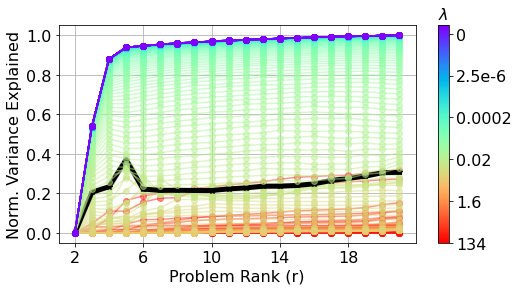

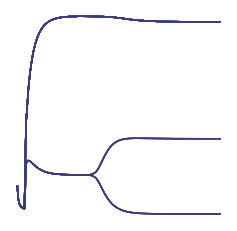

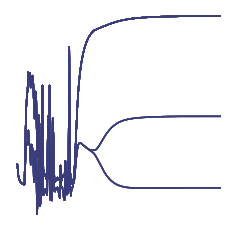

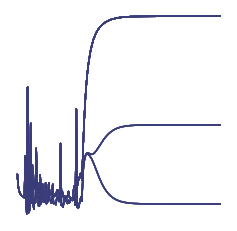

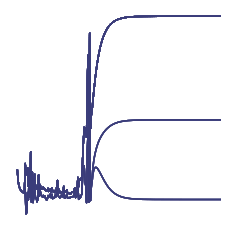

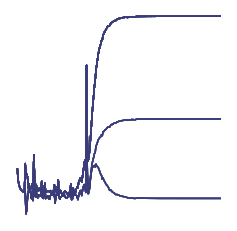

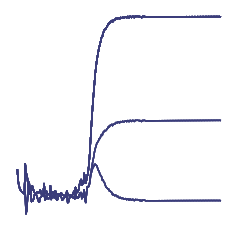

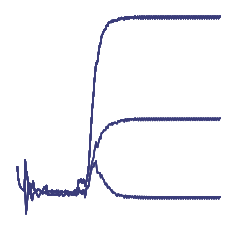

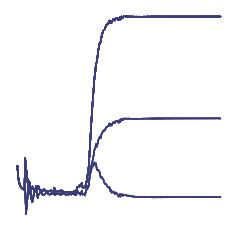

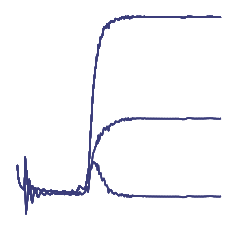

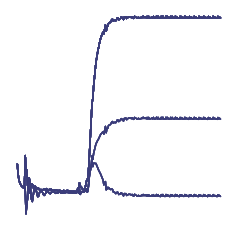

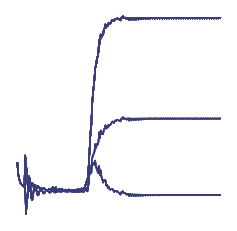

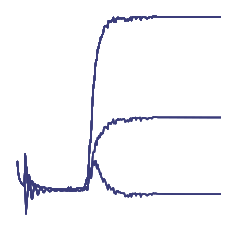

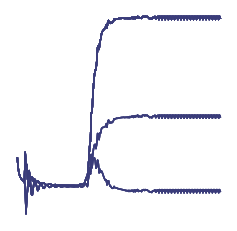

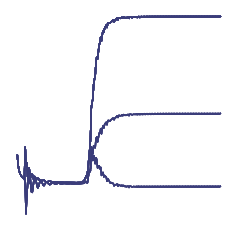

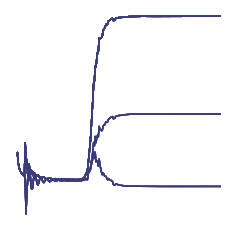

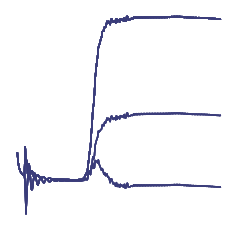

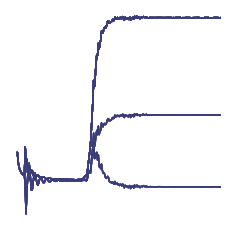

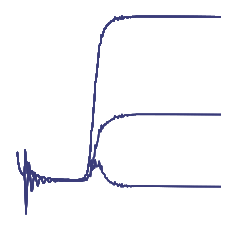

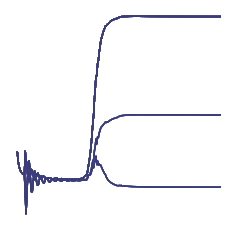

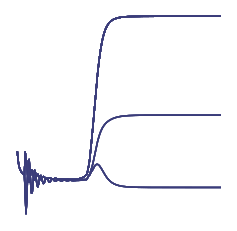

In [294]:
plot_variance_byrank(Ss,As,true_clusters,0,penalty_list, fontsize=16, max_rank=X_c.shape[1])


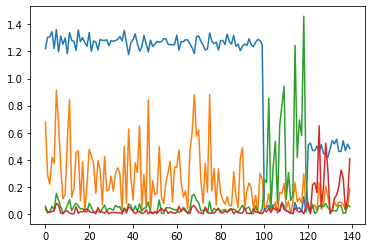

In [245]:
plt.plot(np.abs(U_list[150][:,:]*s_list[150]))
